# **Classification**

In [1]:
!nvidia-smi

Wed Oct 26 23:47:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     8W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
###############################################################################
### Project: Multi-class Classification
### Model: Base Model
### ACC:          FLOPs:
###############################################################################

In [3]:
# Importing libraries. 
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision
from torchvision import datasets, transforms, models 
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

#get flops
#The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
#Download the code.
!wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
!mv download FLOPs_counter.py
#!rm -rf download
from FLOPs_counter import print_model_parm_flops

%matplotlib inline

--2022-10-26 23:47:57--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=ul34ph7eg95td3rql1h8ahr5jl; path=/plus;; Secure at position 53.
Syntax error in Set-Cookie: oc_sessionPassphrase=M%2Fz0UcUzA3X8DARrUCjZk5WcsNNcA0GGv4ZKNr2y6AyHQp42v5yqrtAe%2FJrV9uF0xAIBN%2FYS08P3%2FKX1sSeWgVElaDqCQJ%2F2n1truMXETqUmb6gyRXWiKWDyDU62h6m9; expires=Thu, 27-Oct-2022 23:47:58 GMT; Max-Age=86400; path=/plus;; Secure at position 226.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2022-10-26 23:47:59 (521 MB/s) - ‘download’ saved [5201/5201]



## **1. Loading and Analysing the dataset**

In [4]:
class Data():
    def __init__(self,batch_size):
        self.batch_size = batch_size
        
    def data_augmentation(self,model='Normalization'):
        data_transform = None
        if model=='Normalization': 
            print('Data augmentation: Normalization')
            data_transform = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        elif model== 'Normalization + ColorJitter':
            print('Data augmentation: Normalization + ColorJitter')
            data_transform = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ColorJitter(brightness=.5, hue=.3),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])
        elif model == 'Normalization + RandomAffine':
            print('Data augmentation: Normalization + RandomAffine')
            data_transform = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        return data_transform


    def loading_data(self,dataset='CIFAR10',model='Normalization'):
        print('Data Information')
        print('='*30)
        print('Batch size:',self.batch_size)
        data_transform = self.data_augmentation(model)
        print('='*30)
        if dataset == 'CIFAR10':
            print('Dataset name: ', dataset)
            # Load data set
            train_set = torchvision.datasets.CIFAR10(root='.\data', download=True, train=True,transform=data_transform)
            test_set = torchvision.datasets.CIFAR10(root='.\data', download=True, train=False,transform=data_transform)
            classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        # Setting seed so that value won't change everytime. 
        torch.manual_seed(10) 
        # Random split training set to training set and validation set
        train_set_size = int(len(train_set) * 0.8)
        valid_set_size = len(train_set) - train_set_size
        train_set, valid_set = torch.utils.data.random_split(train_set, [train_set_size, valid_set_size])

        print('='*30)
        print('Train data set:', len(train_set))
        print('Valid data set:', len(valid_set))
        print('Test data set:', len(test_set))

        # loader
        train_loader = DataLoader(train_set, batch_size=self.batch_size,
                                              shuffle=True, num_workers=2,pin_memory=True)
        val_loader = DataLoader(valid_set, batch_size=self.batch_size,
                                              num_workers=2,pin_memory=True)
        test_loader = DataLoader(test_set, batch_size=self.batch_size,
                                              num_workers=2,pin_memory=True)
        return [train_loader,val_loader,test_loader,classes]
    
    def imshow(self,img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        fig, ax = plt.subplots(figsize=(18,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
        
    def preview(self,dataloader):
        # get some random training images
        dataiter = iter(dataloader)
        images, labels = dataiter.next()

        # show images
        self.imshow(torchvision.utils.make_grid(images,nrow=16))
        # print labels
        print(' '.join('%6s' % classes[labels[j]] for j in range(self.batch_size)))
        

Data Information
Batch size: 16
Data augmentation: Normalization
Dataset name:  CIFAR10
Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 224, 224])
Train data set: 40000
Valid data set: 10000
Test data set: 10000


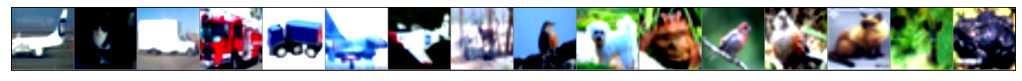

 plane    cat  truck  truck  truck  plane  plane   deer   bird    dog   frog   bird   bird    cat   deer   frog


In [ ]:
# data 
batch_size=16
data = Data(batch_size)
train_loader,val_loader,test_loader,classes =\
    data.loading_data(model = 'Normalization')
data.preview(train_loader)

## 2. Device 

In [5]:
 # To check wether Google Colab GPU has been assigned/not. 
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
#device
device = get_default_device()
print(device)
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

cuda


## **3. Base Model**

In [9]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(nn.Module):
    def __init__(self,n_classes):
        super(ConvolutionalNetwork,self).__init__()
        # input size: 3 x 224 x 224
        self.num_classes=n_classes 
        self.conv1=nn.Conv2d(3, 32, kernel_size=5, stride=1,padding=2)
        self.conv2=nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3=nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.fc1=nn.Linear(128*28*28,512)
        self.fc2=nn.Linear(512,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2) # output: 32 x 112 x 112
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2) # output: 64 x 56 x 56
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2) # output: 128 x 28 x 28
        X=X.view(-1,128*28*28)
        X=F.relu(self.fc1(X))
        X=self.fc2(X)
      
        return F.log_softmax(X, dim=1)

In [6]:
# get parameters
def get_model_parm_nums(model):
  n_parm = sum([param.nelement() for param in model.parameters()])
  print(' + Number of params: %.2f(e6)' % (n_parm / 1e6))
  return n_parm

# Getting flop
def get_flops(model):  
    input = torch.randn(1, 3, 224, 224) # The input size should be the same as the size that you put into your model 
    #Get the network and its FLOPs
    flops = print_model_parm_flops(model, input, detail=False)
    return flops

In [7]:
# Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
class ClassificationBase():
    def __init__(self, model, n_classes, classes, batch_size, n_epochs, loss_func, opt_func, lr):
        self.model = model
        self.n_classes = n_classes
        self.classes = classes
        self.batch_size = batch_size
        self.epochs = n_epochs
        self.criterion = loss_func
        self.optimizer = opt_func# define optimizer function
        self.lr = lr
        
    def train(self,train_loader):
        optimizer = self.optimizer(self.model.parameters(),self.lr,momentum=0.9)
        correct = 0
        total = 0
        train_losses = []
        for batch, data in enumerate(train_loader,0):
            # get the inputs; data is a list of [inputs,lables]
            inputs, labels = data

            # zero the paramter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = self.model(inputs)           # Generate predictions
            loss = self.criterion(outputs,labels)  # Calculate loss
            train_losses.append(loss.item())
            # the class with the highest energy is what we choode as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss.backward()
            optimizer.step()
        train_loss = np.sum(train_losses)/len(train_losses)
        train_acc = 100*correct//total
        return train_loss,train_acc
     
    def validation(self,val_loader):
        correct = 0
        total = 0
        val_losses = []
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                outputs = self.model(images)        # Generate predictions
                loss = self.criterion(outputs, labels)  # Calculate loss
                val_losses.append(loss.item())
                # the class with the highest energy is what we choode as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss = np.sum(val_losses)/len(val_losses)
        val_acc = 100*correct//total
        return val_loss,val_acc

    def test(self,test_loader):
        # prepare to count predictions for each class
        correct_pred = {classname: 0 for classname in self.classes}
        total_pred = {classname: 0 for classname in self.classes}
        correct = 0
        total = 0
        test_losses = []
        # no gradients needed
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = self.model(images) # Generate predictions
                loss = self.criterion(outputs, labels)  # Calculate loss
                test_losses.append(loss.item())
                _, predictions = torch.max(outputs, 1)
                
                # the class with the highest energy is what we choode as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
                # collect the correct predictions for each class
                for label, prediction in zip(labels,predictions):
                    if label ==  prediction:
                        correct_pred[classes[label]] += 1
                    total_pred[classes[label]] += 1
        
        # print test accuracy and test loss
        test_loss = np.sum(test_losses)/len(test_losses)
        test_acc = 100*correct//total
        print(f'test_loss: {test_loss:.4f}, test_acc: {test_acc:.4f}%')
        print('='*40)
        # print accuracy for each class
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print(f'Accuracy for class: {classname:5s} is {accuracy:.1f}%')
        return test_loss,test_acc

    # incorrectly classified
    def Find_fail_case(self):
      incorrect_examples = []
      incorrect_labels = []
      incorrect_pred = []

      # no gradients needed
      with torch.no_grad():
          for data in test_loader:
              images, labels = data
              outputs = self.model(images) # Generate predictions
              pred = torch.max(outputs, 1,keepdim=True) # pred will be a 2d tensor of shape [batch size, 1]
              idx_mask = ((pred == labels.view_as(pred)) == False).view(-1)
              if idx_mask.numel():
                incorrect_examples.append(images[idx_mask].squeeze().cpu().numpy())
                incorrect_labels.append(images[idx_mask].squeeze().cpu().numpy())
                incorrect_pred.append(images[idx_mask].squeeze().cpu().numpy())
      return [incorrect_examples, incorrect_labels, incorrect_pred]
              
            
    def fit(self,train_loader, val_loader):
        history = []
        for epoch in range(self.epochs): #loop over the dataset multiple times
            result = dict()
            # Training step
            self.model.train()
            result['train_loss'],result['train_acc'] = self.train(train_loader)
            # Validation step
            self.model.eval()
            result['val_loss'],result['val_acc'] = self.validation(val_loader)
            print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}%, val_loss: {:.4f}, val_acc: {:.4f}%".format(
            epoch+1, result['train_loss'], result['train_acc'],result['val_loss'], result['val_acc']))
            history.append(result)
        return history
    
    # Visualization
    def plot_accuracies(self,history):
        train_accuracies = [x['train_acc'] for x in history]
        val_accuracies = [x['val_acc'] for x in history]
        plt.plot(train_accuracies, '-bx')
        plt.plot(val_accuracies, '-rx')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['Training', 'Validation'])
        plt.title('Accuracy vs. No. of epochs')
        plt.show()
    
    def plot_losses(self,history):
        train_losses = [x['train_loss'] for x in history]
        val_losses = [x['val_loss'] for x in history]
        plt.plot(train_losses, '-bx')
        plt.plot(val_losses, '-rx')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['Training', 'Validation'])
        plt.title('Loss vs. No. of epochs')
        plt.show()

## **3. Experiment**

Data Information
Batch size: 16
Data augmentation: Normalization
Dataset name:  CIFAR10
Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 224, 224])
Train data set: 40000
Valid data set: 10000
Test data set: 10000
 + Number of params: 51.64(e6)
 + Number of FLOPs: 2.85G
ConvolutionalNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Epoch [1], train_loss: 1.6004, train_acc: 42.0000%, val_loss: 1.3449, val_acc: 52.0000%
Epoch [2], train_loss: 1.1892, train_acc: 57.0000%, val_loss: 1.1700, val_acc: 58.0000%
Epoch [3], train_loss: 0.9287, train_acc: 67.0000%, val_loss: 1.1052, val_acc: 62.0000%
Epoch [4], train_loss: 0.6564, train_acc: 7

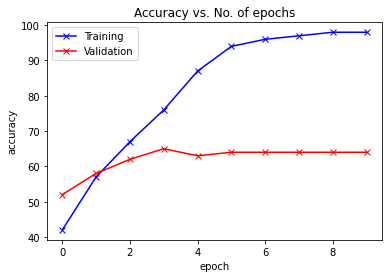

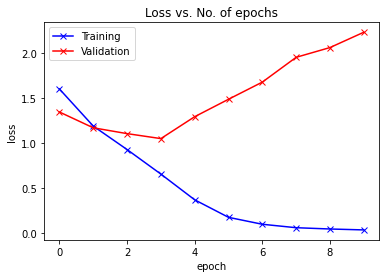

test_loss: 2.2485, test_acc: 64.0000%
Accuracy for class: plane is 72.3%
Accuracy for class: car   is 75.5%
Accuracy for class: bird  is 51.4%
Accuracy for class: cat   is 37.5%
Accuracy for class: deer  is 62.5%
Accuracy for class: dog   is 49.2%
Accuracy for class: frog  is 73.6%
Accuracy for class: horse is 70.9%
Accuracy for class: ship  is 79.6%
Accuracy for class: truck is 75.0%


In [ ]:
# Augmentation
# https://pytorch.org/vision/stable/transforms.html
# data 
batch_size=16
data = Data(batch_size)
train_loader,val_loader,test_loader,classes =\
    data.loading_data(model='Normalization')
#device
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
# CNN -- base model
n_classes = 10
print('='*40)
model = ConvolutionalNetwork(n_classes)
# model parameters and flops
n_parm = get_model_parm_nums(model)
flops = get_flops(model)
print(to_device(model, device))
print('='*40)
# hyperparameters
n_epochs = 10
lr = 0.001
loss_func = nn.CrossEntropyLoss()
opt_func= torch.optim.SGD
# Train and Evaluate Model
baseline = ClassificationBase(model,n_classes,classes,batch_size,n_epochs,loss_func,opt_func,lr)
history = baseline.fit(train_loader, val_loader)
baseline.plot_accuracies(history)
baseline.plot_losses(history)
print('='*40) 
test = baseline.test(test_loader) 

Data Information
Batch size: 16
Data augmentation: Normalization + ColorJitter
Dataset name:  CIFAR10
Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 224, 224])
Train data set: 40000
Valid data set: 10000
Test data set: 10000
 + Number of params: 51.64(e6)
 + Number of FLOPs: 2.85G
ConvolutionalNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Epoch [1], train_loss: 1.8252, train_acc: 34.0000%, val_loss: 1.5364, val_acc: 45.0000%
Epoch [2], train_loss: 1.3979, train_acc: 50.0000%, val_loss: 1.3443, val_acc: 53.0000%
Epoch [3], train_loss: 1.1174, train_acc: 60.0000%, val_loss: 1.1937, val_acc: 58.0000%
Epoch [4], train_loss: 0.8596

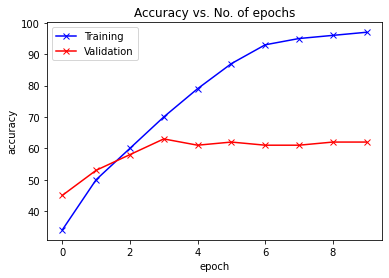

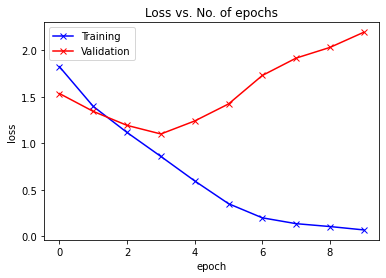

test_loss: 2.2001, test_acc: 62.0000%
Accuracy for class: plane is 57.6%
Accuracy for class: car   is 78.8%
Accuracy for class: bird  is 49.2%
Accuracy for class: cat   is 47.4%
Accuracy for class: deer  is 55.4%
Accuracy for class: dog   is 55.6%
Accuracy for class: frog  is 72.8%
Accuracy for class: horse is 65.2%
Accuracy for class: ship  is 73.8%
Accuracy for class: truck is 69.2%


In [ ]:
# Augmentation
# https://pytorch.org/vision/stable/transforms.html
# data 
batch_size=16
data = Data(batch_size)
train_loader,val_loader,test_loader,classes =\
    data.loading_data(model='Normalization + ColorJitter')
#device
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
# CNN -- base model
n_classes = 10
print('='*40)
model = ConvolutionalNetwork(n_classes)
# model parameters and flops
n_parm = get_model_parm_nums(model)
flops = get_flops(model)
print(to_device(model, device))
print('='*40)
# hyperparameters
n_epochs = 10
lr = 0.001
loss_func = nn.CrossEntropyLoss()
opt_func= torch.optim.SGD
# Train and Evaluate Model
baseline = ClassificationBase(model,n_classes,classes,batch_size,n_epochs,loss_func,opt_func,lr)
history = baseline.fit(train_loader, val_loader)
baseline.plot_accuracies(history)
baseline.plot_losses(history)
print('='*40) 
test = baseline.test(test_loader) 

Data Information
Batch size: 16
Data augmentation: Normalization + RandomAffine
Dataset name:  CIFAR10
Files already downloaded and verified
Files already downloaded and verified
Train data set: 40000
Valid data set: 10000
Test data set: 10000


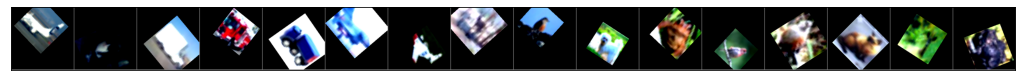

 plane    cat  truck  truck  truck  plane  plane   deer   bird    dog   frog   bird   bird    cat   deer   frog
 + Number of params: 51.64(e6)
 + Number of FLOPs: 2.85G
ConvolutionalNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Epoch [1], train_loss: 1.9424, train_acc: 27.0000%, val_loss: 1.8302, val_acc: 32.0000%
Epoch [2], train_loss: 1.6595, train_acc: 38.0000%, val_loss: 1.5575, val_acc: 42.0000%
Epoch [3], train_loss: 1.5087, train_acc: 44.0000%, val_loss: 1.4892, val_acc: 45.0000%
Epoch [4], train_loss: 1.3898, train_acc: 49.0000%, val_loss: 1.3620, val_acc: 50.0000%
Epoch [5], train_loss: 1.2918, train_acc: 52.0000%, val_loss: 1.2709, val_acc: 53.0000%
Epoch [6],

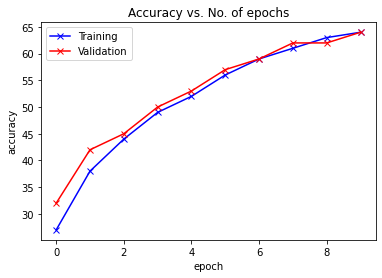

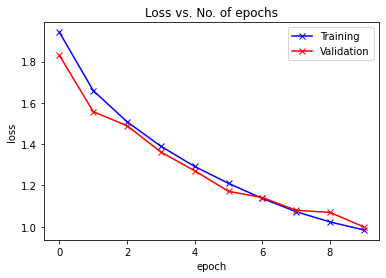

test_loss: 0.9673, test_acc: 65.0000%
Accuracy for class: plane is 67.4%
Accuracy for class: car   is 76.7%
Accuracy for class: bird  is 53.3%
Accuracy for class: cat   is 40.5%
Accuracy for class: deer  is 49.4%
Accuracy for class: dog   is 65.0%
Accuracy for class: frog  is 72.6%
Accuracy for class: horse is 71.6%
Accuracy for class: ship  is 85.0%
Accuracy for class: truck is 73.7%


In [10]:
# Augmentation
# https://pytorch.org/vision/stable/transforms.html
# data 
batch_size=16
data = Data(batch_size)
train_loader,val_loader,test_loader,classes =\
    data.loading_data(model='Normalization + RandomAffine')
data.preview(train_loader)
#device
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# CNN -- base model
n_classes = 10
print('='*40)
model = ConvolutionalNetwork(n_classes)
# model parameters and flops
n_parm = get_model_parm_nums(model)
flops = get_flops(model)
print(to_device(model, device))
print('='*40)
# hyperparameters
n_epochs = 10
lr = 0.001
loss_func = nn.CrossEntropyLoss()
opt_func= torch.optim.SGD
# Train and Evaluate Model
baseline = ClassificationBase(model,n_classes,classes,batch_size,n_epochs,loss_func,opt_func,lr)
history = baseline.fit(train_loader, val_loader)
baseline.plot_accuracies(history)
baseline.plot_losses(history)
print('='*40) 
test = baseline.test(test_loader) 

### learning rate

 + Number of params: 51.64(e6)
 + Number of FLOPs: 2.85G
ConvolutionalNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Epoch [1], train_loss: 2.0568, train_acc: 21.0000%, val_loss: 1.9713, val_acc: 25.0000%
Epoch [2], train_loss: 1.8374, train_acc: 30.0000%, val_loss: 1.7690, val_acc: 33.0000%
Epoch [3], train_loss: 1.7158, train_acc: 36.0000%, val_loss: 1.6513, val_acc: 39.0000%
Epoch [4], train_loss: 1.6383, train_acc: 39.0000%, val_loss: 1.6466, val_acc: 40.0000%
Epoch [5], train_loss: 1.5768, train_acc: 42.0000%, val_loss: 1.5056, val_acc: 44.0000%
Epoch [6], train_loss: 1.5383, train_acc: 44.0000%, val_loss: 1.4985, val_acc: 45.0000%
Epoch [7], train_loss: 1.5023, tra

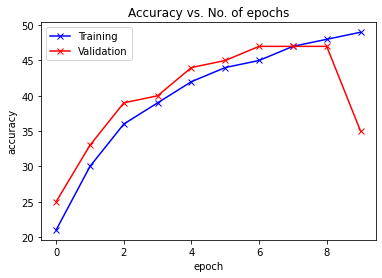

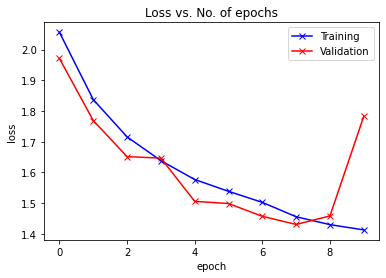

test_loss: 1.7662, test_acc: 35.0000%
Accuracy for class: plane is 35.0%
Accuracy for class: car   is 31.1%
Accuracy for class: bird  is 15.7%
Accuracy for class: cat   is 16.9%
Accuracy for class: deer  is 32.8%
Accuracy for class: dog   is 28.7%
Accuracy for class: frog  is 37.4%
Accuracy for class: horse is 67.2%
Accuracy for class: ship  is 43.3%
Accuracy for class: truck is 46.1%


In [11]:
# Augmentation
# https://pytorch.org/vision/stable/transforms.html
# data 
# batch_size=16
# data = Data(batch_size)
# train_loader,val_loader,test_loader,classes =\
#     data.loading_data(model='Normalization + RandomAffine')
# data.preview(train_loader)
# #device
# device = get_default_device()
# train_loader = DeviceDataLoader(train_loader, device)
# val_loader = DeviceDataLoader(val_loader, device)
# test_loader = DeviceDataLoader(test_loader, device)

# CNN -- base model
n_classes = 10
print('='*40)
model = ConvolutionalNetwork(n_classes)
# model parameters and flops
n_parm = get_model_parm_nums(model)
flops = get_flops(model)
print(to_device(model, device))
print('='*40)
# hyperparameters
n_epochs = 10
lr = 0.01
loss_func = nn.CrossEntropyLoss()
opt_func= torch.optim.SGD
# Train and Evaluate Model
baseline = ClassificationBase(model,n_classes,classes,batch_size,n_epochs,loss_func,opt_func,lr)
history = baseline.fit(train_loader, val_loader)
baseline.plot_accuracies(history)
baseline.plot_losses(history)
print('='*40) 
test = baseline.test(test_loader) 

In [12]:
# Augmentation
# https://pytorch.org/vision/stable/transforms.html
# data 
# batch_size=16
# data = Data(batch_size)
# train_loader,val_loader,test_loader,classes =\
#     data.loading_data(model='Normalization + RandomAffine')
# data.preview(train_loader)
# #device
# device = get_default_device()
# train_loader = DeviceDataLoader(train_loader, device)
# val_loader = DeviceDataLoader(val_loader, device)
# test_loader = DeviceDataLoader(test_loader, device)

# CNN -- base model
n_classes = 10
print('='*40)
model = ConvolutionalNetwork(n_classes)
# model parameters and flops
n_parm = get_model_parm_nums(model)
flops = get_flops(model)
print(to_device(model, device))
print('='*40)
# hyperparameters
n_epochs = 10
lr = 0.1
loss_func = nn.CrossEntropyLoss()
opt_func= torch.optim.SGD
# Train and Evaluate Model
baseline = ClassificationBase(model,n_classes,classes,batch_size,n_epochs,loss_func,opt_func,lr)
history = baseline.fit(train_loader, val_loader)
baseline.plot_accuracies(history)
baseline.plot_losses(history)
print('='*40) 
test = baseline.test(test_loader) 

 + Number of params: 51.64(e6)
 + Number of FLOPs: 2.85G
ConvolutionalNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Epoch [1], train_loss: nan, train_acc: 10.0000%, val_loss: nan, val_acc: 9.0000%
Epoch [2], train_loss: nan, train_acc: 10.0000%, val_loss: nan, val_acc: 9.0000%
Epoch [3], train_loss: nan, train_acc: 10.0000%, val_loss: nan, val_acc: 9.0000%
Epoch [4], train_loss: nan, train_acc: 10.0000%, val_loss: nan, val_acc: 9.0000%


KeyboardInterrupt: ignored

### epoch number

 + Number of params: 51.64(e6)
 + Number of FLOPs: 2.85G
ConvolutionalNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Epoch [1], train_loss: 1.9327, train_acc: 28.0000%, val_loss: 1.7601, val_acc: 34.0000%
Epoch [2], train_loss: 1.6514, train_acc: 39.0000%, val_loss: 1.5784, val_acc: 42.0000%
Epoch [3], train_loss: 1.5096, train_acc: 44.0000%, val_loss: 1.4514, val_acc: 46.0000%
Epoch [4], train_loss: 1.4061, train_acc: 48.0000%, val_loss: 1.3698, val_acc: 49.0000%
Epoch [5], train_loss: 1.3139, train_acc: 52.0000%, val_loss: 1.2717, val_acc: 53.0000%
Epoch [6], train_loss: 1.2354, train_acc: 55.0000%, val_loss: 1.2157, val_acc: 56.0000%
Epoch [7], train_loss: 1.1586, tra

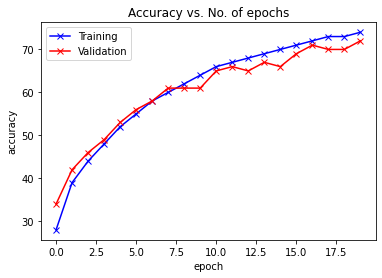

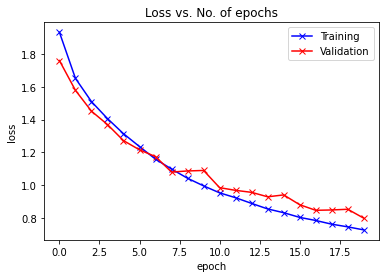

test_loss: 0.7857, test_acc: 72.0000%
Accuracy for class: plane is 72.7%
Accuracy for class: car   is 81.6%
Accuracy for class: bird  is 61.6%
Accuracy for class: cat   is 51.9%
Accuracy for class: deer  is 62.6%
Accuracy for class: dog   is 69.6%
Accuracy for class: frog  is 83.5%
Accuracy for class: horse is 73.7%
Accuracy for class: ship  is 85.1%
Accuracy for class: truck is 87.4%


In [13]:
# Augmentation
# https://pytorch.org/vision/stable/transforms.html
# data 
# batch_size=16
# data = Data(batch_size)
# train_loader,val_loader,test_loader,classes =\
#     data.loading_data(model='Normalization + RandomAffine')
# data.preview(train_loader)
# #device
# device = get_default_device()
# train_loader = DeviceDataLoader(train_loader, device)
# val_loader = DeviceDataLoader(val_loader, device)
# test_loader = DeviceDataLoader(test_loader, device)

# CNN -- base model
n_classes = 10
print('='*40)
model = ConvolutionalNetwork(n_classes)
# model parameters and flops
n_parm = get_model_parm_nums(model)
flops = get_flops(model)
print(to_device(model, device))
print('='*40)
# hyperparameters
n_epochs = 20
lr = 0.001
loss_func = nn.CrossEntropyLoss()
opt_func= torch.optim.SGD
# Train and Evaluate Model
baseline = ClassificationBase(model,n_classes,classes,batch_size,n_epochs,loss_func,opt_func,lr)
history = baseline.fit(train_loader, val_loader)
baseline.plot_accuracies(history)
baseline.plot_losses(history)
print('='*40) 
test = baseline.test(test_loader) 

Data Information
Batch size: 32
Data augmentation: Normalization + RandomAffine
Dataset name:  CIFAR10
Files already downloaded and verified
Files already downloaded and verified
Train data set: 40000
Valid data set: 10000
Test data set: 10000


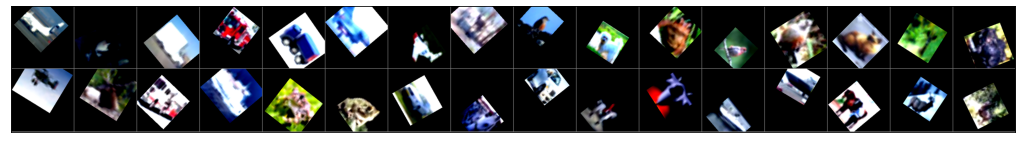

 plane    cat  truck  truck  truck  plane  plane   deer   bird    dog   frog   bird   bird    cat   deer   frog  plane   deer  truck   ship   frog   frog    car  horse    car  horse  plane   ship   ship  horse   deer   deer
 + Number of params: 51.64(e6)
 + Number of FLOPs: 2.85G
ConvolutionalNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Epoch [1], train_loss: 2.0035, train_acc: 25.0000%, val_loss: 1.8510, val_acc: 31.0000%
Epoch [2], train_loss: 1.7627, train_acc: 34.0000%, val_loss: 1.6708, val_acc: 38.0000%
Epoch [3], train_loss: 1.6094, train_acc: 40.0000%, val_loss: 1.5838, val_acc: 41.0000%
Epoch [4], train_loss: 1.5221, train_acc: 43.0000%, val_loss: 1.5039, val_

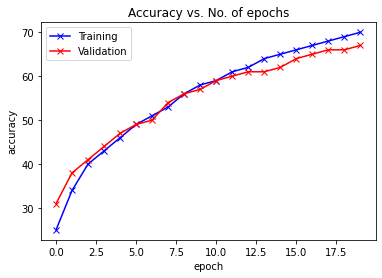

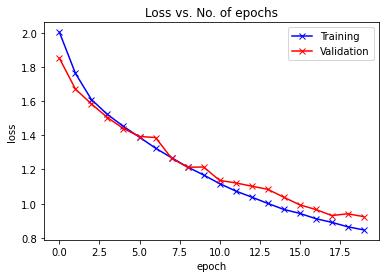

test_loss: 0.9236, test_acc: 67.0000%
Accuracy for class: plane is 68.8%
Accuracy for class: car   is 83.2%
Accuracy for class: bird  is 55.5%
Accuracy for class: cat   is 45.0%
Accuracy for class: deer  is 54.2%
Accuracy for class: dog   is 67.7%
Accuracy for class: frog  is 77.5%
Accuracy for class: horse is 66.4%
Accuracy for class: ship  is 84.0%
Accuracy for class: truck is 74.2%


In [15]:
# Augmentation
# https://pytorch.org/vision/stable/transforms.html
# data 
batch_size=32
data = Data(batch_size)
train_loader,val_loader,test_loader,classes =\
    data.loading_data(model='Normalization + RandomAffine')
data.preview(train_loader)
#device
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# CNN -- base model
n_classes = 10
print('='*40)
model = ConvolutionalNetwork(n_classes)
# model parameters and flops
n_parm = get_model_parm_nums(model)
flops = get_flops(model)
print(to_device(model, device))
print('='*40)
# hyperparameters
n_epochs = 20
lr = 0.001
loss_func = nn.CrossEntropyLoss()
opt_func= torch.optim.SGD
# Train and Evaluate Model
baseline = ClassificationBase(model,n_classes,classes,batch_size,n_epochs,loss_func,opt_func,lr)
history = baseline.fit(train_loader, val_loader)
baseline.plot_accuracies(history)
baseline.plot_losses(history)
print('='*40) 
test = baseline.test(test_loader) 

### batch size